In [1]:
%matplotlib inline
import pathlib as pl
import numpy as np
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import rasterio.warp
from shapely.geometry import shape

import scipy.sparse as sparse

import flopy
import flopy.plot.styles as styles

from gdptools import WeightGenP2P

In [2]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, get_dflow_grid_name, get_modflow_coupling_tag, get_modflow_grid_name

In [3]:
control_path = pl.Path("../dflow-fm/coarse/tides_2018/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)

LIS_GPT_PJ_cells3_net


In [4]:
mf_grid_name = get_modflow_grid_name()
print(mf_grid_name)

greenport_chd


In [5]:
get_modflow_coupling_tag(1.)

'01.00H'

## Read the D-Flow FM output file

Make sure you run D-Flow FM by itself first so that there is an output NetCDF file available so that the mapping is done using the internal node order

In [6]:
# use an output file because this is what will be available from bmi and is in the correct order
source_path = "../dflow-fm/coarse/tides_2018/run/output/FlowFM_map.nc"
source_ds = xugrid.open_dataset(source_path)

In [7]:
source_ds

<xarray.Dataset> Size: 85MB
Dimensions:                      (mesh2d_nNodes: 13365, mesh2d_nEdges: 35029,
                                  mesh2d_nFaces: 21660,
                                  mesh2d_nMax_face_nodes: 4, time: 25)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 107kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 107kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 280kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 280kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 173kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 173kB ...
  * time                         (time) datetime64[ns] 200B 2018-01-01 ... 20...
  * mesh2d_nEdges                (mesh2d_nEdges) int64 280kB 0 1 ... 35027 35028
  * mesh2d_nFaces                (mesh2d_nFaces) int64 173kB 0 1 ... 21658 21659
  * mesh2d_nNodes                (mesh2d_nNodes) int64 107kB 0 1 ... 13363 13364
Dimensions without coordinates: mesh2d_nMax_face_nodes
Data variables: (12/23)
    projected_coordinate_system  int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 107kB ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 693kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 693kB ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 280kB ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 173kB ...
    ...                           ...
    mesh2d_q1                    (time, mesh2d_nEdges) float64 7MB ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 7MB ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 7MB ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 4MB ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 4MB ...
    mesh2d_czu                   (time, mesh2d_nEdges) float64 7MB ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.123.69078M. Model:
    history:        Created on 2025-07-29T15:28:35-0400, D-Flow FM
    date_created:   2025-07-29T15:28:35-0400
    date_modified:  2025-07-29T15:28:35-0400
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10

In [8]:
print(source_ds.grid.face_node_connectivity.shape)
source_ds.grid.face_node_connectivity

(21660, 4)


array([[13296,     0,     1,  -999],
       [    3,     2,     0,  -999],
       [    1,     0,     2,  -999],
       ...,
       [13295, 13291, 13287, 13293],
       [13288, 13291, 13290, 13286],
       [13295, 13294, 13290, 13291]], dtype=int64)

In [9]:
print(source_ds.grid.node_face_connectivity.shape)
source_ds.grid.node_face_connectivity

(13365, 21660)


<13365x21660 sparse matrix of type '<class 'numpy.int32'>'
	with 68795 stored elements in Compressed Sparse Row format>

### Convert the NetCDF data to a geodataframe

In [10]:
source_gdf = source_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")

In [11]:
source_gdf.set_crs(32618, inplace=True)

,cell,mesh2d_face_x,mesh2d_face_y,geometry
mesh2d_nFaces,,,,
0,0,581304.782862,4.530140e+06,"POLYGON ((581278.095 4530797.658, 580803.668 4..."
1,1,580948.525069,4.529244e+06,"POLYGON ((580509.155 4529024.860, 581120.782 4..."
2,2,581165.501727,4.529318e+06,"POLYGON ((581637.189 4529571.190, 580803.668 4..."
3,3,580708.393782,4.528634e+06,"POLYGON ((580509.155 4529024.860, 580305.524 4..."
4,4,581718.153967,4.528955e+06,"POLYGON ((581930.574 4528371.125, 581637.189 4..."
...,...,...,...,...
21655,21655,698004.338382,4.540132e+06,"POLYGON ((697883.097 4539946.737, 698216.083 4..."
21656,21656,698641.288943,4.539406e+06,"POLYGON ((698946.834 4539209.344, 698783.296 4..."
21657,21657,697760.020796,4.539259e+06,"POLYGON ((698001.058 4539041.376, 697939.776 4..."


## Open the shapefile with the location of the coastal boundaries in MODFLOW

The shapefile needs to be limited to coastal boundary locations and be in the same coordinate system as the D-Flow FM model (UTM 18N).

In [12]:
fpth = f"../modflow/gis/{mf_grid_name}_ghb_utm18n.shp"
print(fpth)

../modflow/gis/greenport_chd_ghb_utm18n.shp


In [13]:
target_coastal = gpd.read_file(fpth) # this is the shapefile with coastal boundary conditions
target_coastal

,head,cond,salinity,boundname,layer,row,column,ghb_no,geometry
0,0.234,4835.190,27.119,wetland,0,11,53,0,"POLYGON ((723969.935 4557362.289, 724114.352 4..."
1,0.234,4734.790,27.119,wetland,0,11,54,1,"POLYGON ((724114.352 4557411.074, 724258.770 4..."
2,0.234,4173.495,27.119,wetland,0,12,53,2,"POLYGON ((724018.720 4557217.870, 724163.138 4..."
3,0.234,5556.300,27.119,wetland,0,12,54,3,"POLYGON ((724163.138 4557266.655, 724307.556 4..."
4,0.234,4906.405,27.119,wetland,0,13,52,4,"POLYGON ((723923.088 4557024.666, 724067.506 4..."
...,...,...,...,...,...,...,...,...,...
67,0.234,4709.165,27.119,wetland,0,41,10,67,"POLYGON ((719223.708 4550932.033, 719368.118 4..."
68,0.234,5475.300,27.119,wetland,0,41,11,68,"POLYGON ((719368.118 4550980.813, 719512.529 4..."
69,0.234,4807.035,27.119,wetland,0,42,10,69,"POLYGON ((719272.481 4550787.617, 719416.891 4..."
70,0.234,4477.235,27.119,wetland,0,42,11,70,"POLYGON ((719416.891 4550836.397, 719561.302 4..."


In [14]:
target_coastal.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

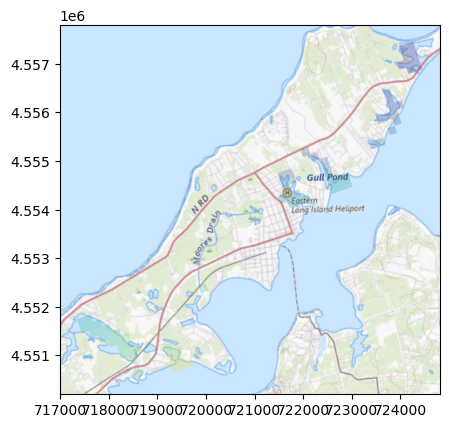

In [15]:
ax = target_coastal.plot(alpha=0.25, column="ghb_no")
cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

## Create the D-FLOW FM to GHB mapping

In [16]:
# generate the weights
weight_gen = WeightGenP2P(
    target_poly=target_coastal,
    target_poly_idx="ghb_no",
    source_poly=source_gdf,
    source_poly_idx=["cell"],
    method="serial",
    weight_gen_crs=32618,
)
weights = weight_gen.calculate_weights()

Using serial engine
Reprojecting to epsg:EPSG:32618 finished in 0.0 second(s)
Validating polygons
     - validating source polygons
     - fixing 0 invalid polygons.
     - validating target polygons
     - fixing 0 invalid polygons.
Validate polygons finished in 0.0931 seconds
Intersections finished in 0.0339 seconds
Weight gen finished in 0.1282 seconds


In [17]:
weights[:12]

,ghb_no,cell,wght
0,0,11797,0.007026
1,0,11796,0.314514
2,0,11960,0.678460
3,1,11796,0.646965
4,1,11960,0.001546
5,1,11629,0.351488
6,2,11461,0.002284
7,2,11630,0.644761
8,2,11797,0.079542
9,2,11796,0.270499


In [18]:
map_shape = (target_coastal.shape[0], source_gdf.shape[0])
map_shape

(72, 21660)

In [19]:
dflow2mfghb = np.zeros(map_shape, dtype=float)
print(f"{dflow2mfghb.shape}\n{dflow2mfghb}")

(72, 21660)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
for r,c,v in zip(weights["ghb_no"], weights["cell"], weights["wght"]):
    dflow2mfghb[int(r),int(c)] = v

## Create the ghb masking array

Where the sums of the weights along a row are not equal to ~1.0

In [21]:
mask_idx = np.isclose(dflow2mfghb.sum(axis=1), 1.0)
print(f"{mask_idx.sum()}\n{mask_idx.shape}\n{mask_idx}")

72
(72,)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


### Test the D-FLOW FM to GHB mapping

In [22]:
s = np.full(source_gdf.shape[0], 1.0)
h = np.full(mask_idx.shape, 2.0)
h[mask_idx] = dflow2mfghb.dot(s)[mask_idx]
s.shape, dflow2mfghb.shape, h.shape

((21660,), (72, 21660), (72,))

In [23]:
print(f"{h.sum()}\n{h}")

71.99999999999982
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Test with a nan

In [24]:
s = np.random.random(source_gdf.shape[0])
s[1544] = -1e30
print(s)

[0.90539226 0.85112272 0.59097572 ... 0.35373745 0.7124255  0.23585332]


In [25]:
h = np.full(mask_idx.shape, 2.0)
h = dflow2mfghb.dot(s)
h.shape

(72,)

In [26]:
print(f"{h.sum()}\n{h}")

36.24927975291068
[0.44979393 0.63709676 0.563054   0.71895134 0.26667995 0.50885695
 0.59332446 0.34205868 0.21911896 0.54934604 0.78338371 0.53371141
 0.8883615  0.40514676 0.49017928 0.62056619 0.44553803 0.88474165
 0.14866851 0.4410564  0.72157909 0.47960103 0.53273676 0.66872245
 0.60885103 0.75273759 0.45147945 0.47363991 0.58474576 0.39847692
 0.38554415 0.64446587 0.71753966 0.36875753 0.64030706 0.74435682
 0.69646344 0.71654669 0.61641832 0.23380702 0.59943687 0.49164841
 0.33585902 0.40734791 0.37740303 0.40315401 0.20808899 0.78120621
 0.59795413 0.76055506 0.29734643 0.70348722 0.14319692 0.15838397
 0.21510325 0.33615328 0.60220048 0.57197102 0.47843803 0.62927261
 0.38104083 0.37347386 0.44891046 0.78472936 0.4128396  0.54907229
 0.51498514 0.20253778 0.38184606 0.45215872 0.24698199 0.47608574]


## Create the GHB to Qext mapping

In [27]:
ghb2qext = np.transpose(dflow2mfghb.copy())

### Test the GHB to Qext mapping

In [28]:
q = np.full(ghb2qext.shape[1], 1.0)

In [29]:
qext = ghb2qext.dot(q)

In [30]:
print(f"{qext.sum()}\n{qext.shape}")

71.99999999999982
(21660,)


## Save the mapping arrays

In [31]:
fpath = f"../mapping/dflow_{grid_name}_to_{mf_grid_name}_ghb.npz"
np.savez_compressed(fpath, dflow2mfghb=dflow2mfghb, ghbmask=mask_idx, ghb2qext=ghb2qext)